In [1]:
import os
import sys

import matplotlib.pyplot as plt

os.chdir('..')

import numpy as np
import torch
import pandas as pd
from models.TrainPlanningOperator2D import PlanningOperator2D
from heuristics import generaterandompos
from heuristics import euclideannorm, FMM, dijkstra, planningoperator, highresFMM, scikitFMM
from heuristics import testheuristiconmaps, testheuristiconsinglemap

from scipy import ndimage
from matplotlib.patches import Patch


In [2]:
i = 10
j = 0
maps_512x512 = np.load('dataset/street_maps_512.npy')
maps_1024x1024 = np.load('dataset/street_maps_1024.npy')

mapx = 1-maps_512x512[i,:,:].reshape(1,512,512)
mapx_hres = 1-maps_1024x1024[j,:,:].reshape(1,1024,1024)

goalx = generaterandompos(mapx)

map = 1-np.squeeze(mapx,axis=0)
highresmap = 1-np.squeeze(mapx_hres,axis=0)
goal = np.squeeze(goalx,axis=0)




In [3]:
# map = np.ones((512,512),dtype=int)
# highresmap = np.ones((1024,1024),dtype=int)

value_fmm,t_fmm = FMM(map,goal)
value_high_res_fmm,t_res_fmm= highresFMM(highresmap,goal)
value_scifmm,t_scifmm = scikitFMM(map,goal)
value_dijkstra,t_dijkstra = dijkstra(map,goal)

value_eucldn,t_eucl = euclideannorm(map,goal)

value_dijkstra = np.where(value_dijkstra>10e6, 0, value_dijkstra)

fmm_error = ((value_fmm-value_dijkstra))
fmm_error = np.where(map==1,0,fmm_error)
fmm_error = np.where(np.isinf(fmm_error),0,fmm_error)

highres_fmm_error = ((value_high_res_fmm-value_dijkstra))
highres_fmm_error = np.where(highresmap[1::2,1::2]==1,0,highres_fmm_error)
highres_fmm_error = np.where(highres_fmm_error>10e2,0,highres_fmm_error)

scifmm_error = ((value_scifmm-value_dijkstra))
scifmm_error = np.where(map==1,0,scifmm_error)
scifmm_error = np.where(np.isinf(scifmm_error),0,scifmm_error)

# dijkstra_error = ((value_dijkstra-value_eucldn))
# dijkstra_error = np.where(map==1,0,dijkstra_error)
# dijkstra_error = np.where(np.isinf(dijkstra_error),0,dijkstra_error)

print("PyFMM took:",t_fmm,
      "\nHigh Res PyFMM took:",t_res_fmm,
      "\nScikit FMM took:",t_scifmm,
      "\nDijkstra took:",t_dijkstra)


PyFMM took: 0.076995849609375 
High Res PyFMM took: 0.4669327735900879 
Scikit FMM took: 0.043961286544799805 
Dijkstra took: 6.6391706466674805


Mean Error: -8.77071109111295


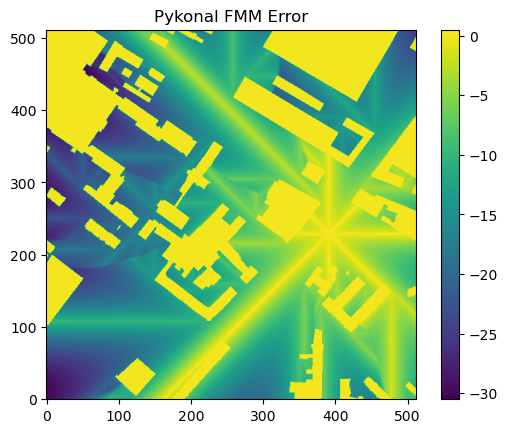

In [4]:
plt.imshow(fmm_error,origin='lower')
plt.title("Pykonal FMM Error")
plt.colorbar()
print("Mean Error:",np.mean(fmm_error))

Mean Error: 39.93663823969792


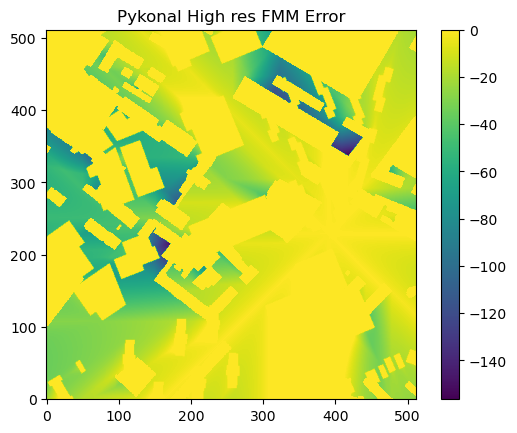

In [5]:
plt.imshow(highres_fmm_error,origin='lower',vmax=0)
plt.title("Pykonal High res FMM Error")
plt.colorbar()
print("Mean Error:",np.mean(highres_fmm_error))

Mean Error: -8.770708519099127


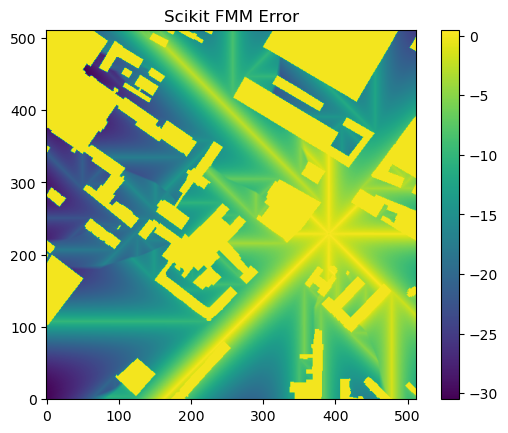

In [6]:
plt.imshow(scifmm_error,origin='lower')
plt.title("Scikit FMM Error")
plt.colorbar()
print("Mean Error:",np.mean(scifmm_error))

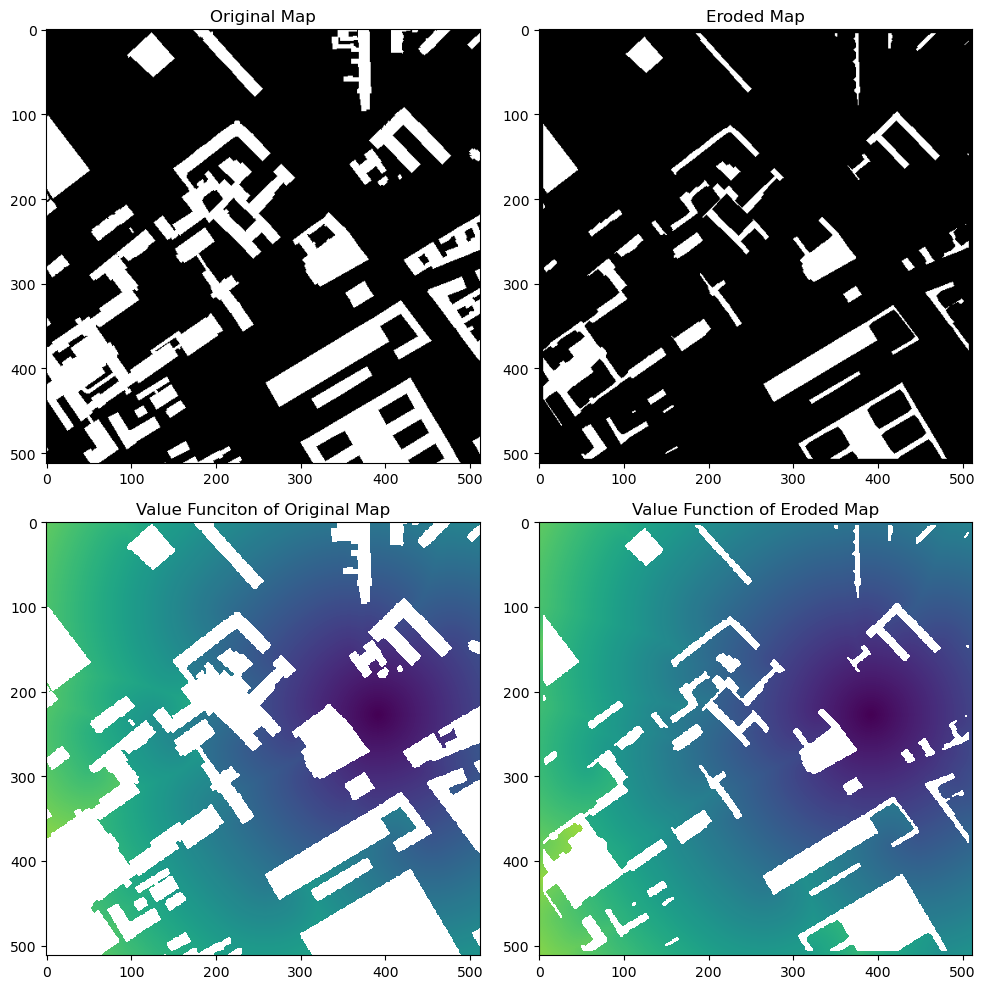

In [13]:
# Erosion
value_fmm,t_fmm = FMM(map,goal)

erosion = 5
eroded_map =  ndimage.binary_erosion(np.array(map),iterations=erosion).astype(np.array(map).dtype)
value_erosion_fmm,t_erosion_fmm = FMM(eroded_map,goal)

# Ensure that the color scale for both FMM plots is the same by determining the common range
# min_value = min(np.min(value_fmm), np.min(value_erosion_fmm))
# max_value = max(np.max(value_fmm), np.max(value_erosion_fmm))

min_value = 0
max_value = 600

# Plotting the map, eroded map, FMM values, and eroded FMM values with the same scale
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Original map
axs[0, 0].imshow(map, cmap='gray')
axs[0, 0].set_title('Original Map')

# Eroded map
axs[0, 1].imshow(eroded_map, cmap='gray')
axs[0, 1].set_title(f'Eroded Map')

# FMM result on original map with the same scale
fmm_original = axs[1, 0].imshow(value_fmm, cmap='viridis', vmin=min_value, vmax=max_value)
axs[1, 0].set_title('Value Funciton of Original Map')

# FMM result on eroded map with the same scale
fmm_eroded = axs[1, 1].imshow(value_erosion_fmm, cmap='viridis', vmin=min_value, vmax=max_value)
axs[1, 1].set_title('Value Function of Eroded Map')

# Add colorbars for the FMM plots
# fig.colorbar(fmm_original, ax=axs[1, 0])
# fig.colorbar(fmm_eroded, ax=axs[1, 1])

# Display the updated plots
plt.tight_layout()
plt.show()


In [14]:
import pickle

# Create a dictionary to store the maps and FMM values
data_to_store = {
    'map': map,
    'eroded_map': eroded_map,
    'value': value_fmm,
    'value_erosion': value_erosion_fmm
}

# Define the file path to store the data
file_path = "fmm_maps_data.pkl"

# Save the data to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(data_to_store, file)

file_path


'fmm_maps_data.pkl'